# About the forecast

Reading several of the other analyses helped me a lot to understand the data and also to start programming. I tried to implement the methods from the [Time Series Course](https://www.kaggle.com/learn/time-series). So the forecast combines linear regression with XGBoost. Then follows a multistep regression to forecast with the residuals of the boosted hybrid, again using XGBoost.

The main components of many time series are trend, seasonality and serial dependence ([machinelearningmastery.com](https://machinelearningmastery.com/time-series-forecasting/)). The linear regression in the boosted hybrid accounting for the trend and the seasonality extrapolates what XGBoost cannot ([towardsdatascience.com](https://towardsdatascience.com/xgboost-for-time-series-youre-gonna-need-a-bigger-boat-9d329efa6814)). Then the XGBoost Regressor uses the available predictors. The multistep regression following the boosted hybrid accounts for the serial dependence in the time series. 

In [20]:
# the first cell contains the imports and some required funktions
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
from statsmodels.graphics.tsaplots import plot_pacf
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_log_error
from xgboost import XGBRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.multioutput import RegressorChain


# required functions - taken from the time series course and modified
# for plots:

def lagplot(x, y=None, lag=1, standardize=False, ax=None, **kwargs):
    from matplotlib.offsetbox import AnchoredText
    x_ = x.shift(lag)
    if standardize:
        x_ = (x_ - x_.mean()) / x_.std()
    if y is not None:
        y_ = (y - y.mean()) / y.std() if standardize else y
    else:
        y_ = x
    corr = y_.corr(x_)
    if ax is None:
        fig, ax = plt.subplots()
    scatter_kws = dict(
        alpha=0.75,
        s=3,
    )
    line_kws = dict(color='C3', )
    ax = sns.regplot(x=x_,
                     y=y_,
                     scatter_kws=scatter_kws,
                     line_kws=line_kws,
                     lowess=True,
                     ax=ax,
                     **kwargs)
    at = AnchoredText(
        f"{corr:.2f}",
        prop=dict(size="large"),
        frameon=True,
        loc="upper left",
    )
    at.patch.set_boxstyle("square, pad=0.0")
    ax.add_artist(at)
    if lag >= 0:
        ax.set(title=f"Lag {lag}", xlabel=x_.name, ylabel=y_.name)
    if lag < 0:
        ax.set(title=f"Lead {-lag}", xlabel=x_.name, ylabel=y_.name)
    return ax


def plot_lags_leads(x, y=None, lags=6, leads=0, nrows=1, lagplot_kwargs={}, **kwargs):
    import math
    lag_0 = 0
    if y is not None:
        lag_0 = 1 # include lag_0 if correlation instead of autocorrelation 
    kwargs.setdefault('nrows', nrows)
    kwargs.setdefault('ncols', math.ceil((lags + leads + lag_0) / nrows))
    kwargs.setdefault('figsize', (kwargs['ncols'] * 2, nrows * 2 + 0.5))
    nplots = kwargs['nrows'] * kwargs['ncols']
    fig, axs = plt.subplots(sharex=True, sharey=True, squeeze=False, **kwargs)
    for ax, k in zip(fig.get_axes(), range(nplots)):
        if k + 1 <= leads:
            ax = lagplot(x, y, lag = (k + 1) + (leads - nplots), ax=ax, **lagplot_kwargs)
            ax.set_title(f"Lead {-((k + 1) + (leads - nplots))}", fontdict=dict(fontsize=14))
            ax.set(xlabel="", ylabel="")
        elif (k + 1) > leads and (k + 1) - leads - lag_0 <= lags:
            ax = lagplot(x, y, lag = (k + 1) - leads - lag_0, ax=ax, **lagplot_kwargs)
            ax.set_title(f"Lag {(k + 1) - leads - lag_0}", fontdict=dict(fontsize=14))
            ax.set(xlabel="", ylabel="")
        else:
            ax.axis('off')
    plt.setp(axs[-1, :], xlabel=x.name)
    plt.setp(axs[:, 0], ylabel=y.name if y is not None else x.name)
    fig.tight_layout(w_pad=0.1, h_pad=0.1)
    return fig


# for time series:

def make_lags(ts, lags, lead_time=1):
    return pd.concat(
        {
            f'{ts.name}_lag_{f"{i:02}"}': ts.shift(i)
            for i in range(lead_time, lags + lead_time)
        },
        axis=1)

def make_leads(ts, leads):
    return pd.concat(
        {
            f'{ts.name}_lead_{f"{(i-1):02}"}': ts.shift(-i+1)
            for i in range(leads , 0, -1)
        }, 
        axis=1)

def make_multistep_target(ts, steps):
    return pd.concat(
        {f'y_step_{f"{(i+1):02}"}': ts.shift(-i)
         for i in range(steps)},
        axis=1)

# Loading and processing the data sets

In [21]:
# read and format the data sets

train = pd.read_csv(
    '../input/store-sales-time-series-forecasting/train.csv',
    usecols=['store_nbr', 'family', 'date', 'sales', 'onpromotion'],
    dtype={
        'store_nbr': 'category',
        'family': 'category',
        'sales': 'float32',
        'onpromotion': 'uint32',
    },
    parse_dates=['date'],
    infer_datetime_format=True,
)
train['date'] = train.date.dt.to_period('D')
train = train.set_index(['store_nbr', 'family', 'date']).sort_index()

oil = pd.read_csv(
    '../input/store-sales-time-series-forecasting/oil.csv',
    dtype={
        'dcoilwtico': 'float64',
    },
    parse_dates = ['date'], 
    infer_datetime_format = True,
)    
oil = oil.set_index('date').to_period('D')

holidays_events = pd.read_csv(
    '../input/store-sales-time-series-forecasting/holidays_events.csv',
    dtype={
        'type': 'category',
        'locale': 'category',
        'locale_name': 'category',
        'description': 'category',
        'transferred': 'bool',
    },
    parse_dates=['date'],
    infer_datetime_format=True,
)
holidays_events = holidays_events.set_index('date').to_period('D')

test = pd.read_csv(
    '../input/store-sales-time-series-forecasting/test.csv',
    dtype={
        'store_nbr': 'category',
        'family': 'category',
        'onpromotion': 'uint32',
    },
    parse_dates=['date'],
    infer_datetime_format=True,
)
test['date'] = test.date.dt.to_period('D')
test = test.set_index(['store_nbr', 'family', 'date']).sort_index()


# treating missing dates in the data sets

# there are missing dates in the training data set
trange = pd.DataFrame(index = pd.date_range('2013-01-01', '2017-08-15', name='date')).to_period('D') # actual training date range
train = train.unstack(['store_nbr', 'family'])
train = train.join(trange, how='right') # joins train with complete training range
#train.isnull().sum().sum() # = 14256
#dec25th = train[train.isnull().any(axis=1)] # find rows with NaN
train = train.fillna(0) # fill with zeros as stores are closed on 25th of December
train = train.stack(['store_nbr', 'family'])

# oil data set also has missing dates
oilrange = pd.DataFrame(index = pd.date_range('2013-01-01', '2017-08-31', name='date')).to_period('D') # complete date range for oil
oil = oilrange.join(oil, how='left')
#oil.isnull().sum().sum() # = 529
oil['dcoilwtico'] = oil['dcoilwtico'].interpolate(limit_direction='both') # fill NaNs with values in between
oil = oil.squeeze()

display(train)

/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:9138: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (3 levels on the left,1 on the right)
  sort=sort,


onpromotion        sales
date       store_nbr family                                              
2013-01-01 1         AUTOMOTIVE                          0.0     0.000000
                     BABY CARE                           0.0     0.000000
                     BEAUTY                              0.0     0.000000
                     BEVERAGES                           0.0     0.000000
                     BOOKS                               0.0     0.000000
...                                                      ...          ...
2017-08-15 9         POULTRY                             0.0   438.132996
                     PREPARED FOODS                      1.0   154.552994
                     PRODUCE                           148.0  2419.729004
                     SCHOOL AND OFFICE SUPPLIES          8.0   121.000000
                     SEAFOOD                             0.0    16.000000

[3008016 rows x 2 columns]

# Features for the linear regression

The linear regression extrapolates the trend and seasonality in the data. From the perspective that time series consist mainly of level, trend, saisonality and noise it will explain a major part of the data. 

The observable trend, the monthly seasonality and the level are modeled by the deterministic process. Calendar data is also used by the linear regression. It includes the data for the weekly seasonality and the calendar events.

**Deterministic process**

In [22]:
sdate = '2015-01-15' # Start and end of training date range
edate = '2017-08-15'

# sales from training data set as target y
y = train.unstack(['store_nbr', 'family']).drop('onpromotion', axis=1).droplevel(0, axis=1).loc[sdate:edate]

# the deterministic process
fourier = CalendarFourier(freq = 'M', order = 4)
dp = DeterministicProcess(
    index=y.index,
    constant=True,
    order=3,
    seasonal=False,
    additional_terms=[fourier],
    drop=True,
)
X1 = dp.in_sample() # features from deterministic process for training

X1_test = dp.out_of_sample(steps=16) # features for test
X1_test.index.name = 'date'

**Calendar features**

As the calendar events influence the sales they will be included as features.

In [23]:
# the date range of the calendar
calendar = pd.DataFrame(index = pd.date_range('2013-01-01', '2017-08-31', name='date')).to_period('D')

# select the national and regional holidays events
holidays = (
    holidays_events
    .query("locale in ['National', 'Regional']")
    .loc['2013-01-01':'2017-08-31', ['description']]
    .assign(description=lambda x: x.description.cat.remove_unused_categories())
)

# deleting selected enrtries when dates have more than one
holidays = holidays.loc[(holidays['description'] != 'Provincializacion de Imbabura') | ((holidays.index != '2014-06-25'))]
holidays = holidays.loc[(holidays['description'] != 'Puente Navidad') | ((holidays.index != '2014-12-26'))]
holidays = holidays.loc[(holidays['description'] != 'Dia del Trabajo') | ((holidays.index != '2016-05-01'))]
holidays = holidays.loc[(holidays['description'] != 'Dia de la Madre-1') | ((holidays.index != '2016-05-07'))]
holidays = holidays.loc[(holidays['description'] != 'Dia de la Madre') | ((holidays.index != '2016-05-08'))]
holidays = holidays.loc[(holidays['description'] != 'Terremoto Manabi+15')]
holidays = holidays.loc[(holidays['description'] != 'Terremoto Manabi+21')]
holidays = holidays.loc[(holidays['description'] != 'Terremoto Manabi+22')]

# add holidays events to the calendar
calendar = calendar.join(holidays)

# encode the labels
calendar = pd.get_dummies(calendar, columns = ['description'])

# to account for the weekly seasonality
calendar['dayofweek'] = calendar.index.dayofweek
calendar = pd.get_dummies(calendar, columns = ['dayofweek'], drop_first = True) # encode the labels

# the days when salaries are paid out
calendar['15thOfMonth'] = (calendar.index.day == 15).astype(int)
calendar['lastOfMonth'] = (calendar.index.dayofyear == calendar.index.days_in_month).astype(int)

# join deterministic process with calendar
X1 = X1.join(calendar, on='date') 
X1_test = X1_test.join(calendar, on='date')

display(X1)

,const,trend,trend_squared,trend_cubed,"sin(1,freq=M)","cos(1,freq=M)","sin(2,freq=M)","cos(2,freq=M)","sin(3,freq=M)","cos(3,freq=M)",...,description_Traslado Primer dia del ano,description_Viernes Santo,dayofweek_1,dayofweek_2,dayofweek_3,dayofweek_4,dayofweek_5,dayofweek_6,15thOfMonth,lastOfMonth
date,,,,,,,,,,,,,,,,,,,,,
2015-01-15,1.0,1.0,1.0,1.0,0.299363,-0.954139,-0.571268,0.820763,0.790776,-0.612106,...,0,0,0,0,1,0,0,0,1,0
2015-01-16,1.0,2.0,4.0,8.0,0.101168,-0.994869,-0.201299,0.979530,0.299363,-0.954139,...,0,0,0,0,0,1,0,0,0,0
2015-01-17,1.0,3.0,9.0,27.0,-0.101168,-0.994869,0.201299,0.979530,-0.299363,-0.954139,...,0,0,0,0,0,0,1,0,0,0
2015-01-18,1.0,4.0,16.0,64.0,-0.299363,-0.954139,0.571268,0.820763,-0.790776,-0.612106,...,0,0,0,0,0,0,0,1,0,0
2015-01-19,1.0,5.0,25.0,125.0,-0.485302,-0.874347,0.848644,0.528964,-0.998717,-0.050649,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-08-11,1.0,940.0,883600.0,830584000.0,0.897805,-0.440394,-0.790776,-0.612106,-0.201299,0.979530,...,0,0,0,0,0,1,0,0,0,0
2017-08-12,1.0,941.0,885481.0,833237621.0,0.790776,-0.612106,-0.968077,-0.250653,0.394356,0.918958,...,0,0,0,0,0,0,1,0,0,0
2017-08-13,1.0,942.0,887364.0,835896888.0,0.651372,-0.758758,-0.988468,0.151428,0.848644,0.528964,...,0,0,0,0,0,0,0,1,0,0


# Features for XGBoost

Available data for the dates to be predicted in test are oil prices, promotions and lagged values of the target y.

In [24]:
# examine the relationships on the residuals of the linear regression
lnr = LinearRegression(fit_intercept=False)
lnr.fit(X1, y)
y_fit = pd.DataFrame(lnr.predict(X1), index=X1.index, columns=y.columns).clip(0.0)
y_deseasoned = y - y_fit
# grouped by family
y_des_family = ( 
    y_deseasoned
    .stack(['store_nbr','family'])
    .groupby(['family', 'date']).mean()
    .unstack('family')
    .squeeze()
)

**Oil prices**

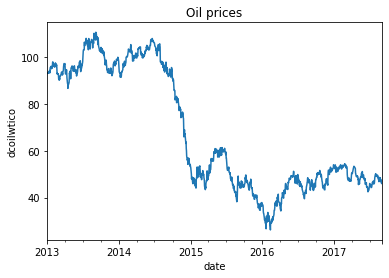

In [25]:
ax = oil.plot(title = 'Oil prices', ylabel='dcoilwtico')

The influence of the oil prices on the detrended target value is very low. To avoid lookahead leakage only actual and lagged values can be used.

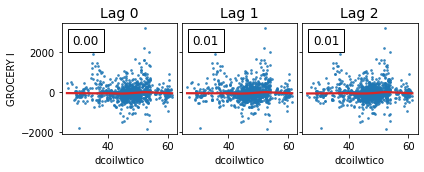

In [26]:
# show the influence of oil prices on sales
ofamily = 'GROCERY I' #'SCHOOL AND OFFICE SUPPLIES'
plot_lags_leads(x=oil.loc[sdate:edate],
                y=y_des_family.loc(axis=1)[ofamily].rename(ofamily), 
                lags=2, nrows=1);

Even if over a longer time horizon, with the data from before 2015, the oil prices show a negative correlation with the non stationary sales. In the shorter run there is a low correlation or even positive correlation, which doesn't seem reasonable. It seems that price shocks can affect the sales by decreasing the incomes. But shifts over weeks or days may not have a an influence on the sales. Did not find a way yet to apply the data set.

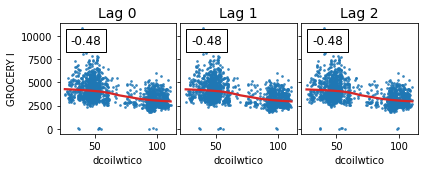

In [27]:
odate='2013-01-01' #'2016-01-01'

# group sales by family
sales_family = ( 
    train
    .unstack(['store_nbr', 'family'])
    .drop('onpromotion', axis=1)
    .droplevel(0, axis=1)
    .stack(['store_nbr','family'])
    .groupby(['family', 'date']).mean()
    .unstack('family')
    .squeeze()
)

# show relationship between oil prices and sales
plot_lags_leads(x=oil.loc[odate:edate], y=sales_family.loc(axis=1)[ofamily].loc[odate:edate].rename(ofamily), lags=2, nrows=1);

**Promotions**

The onpromotions data correlates with the detrended sales. As the stores know about their promotions lagged as well as leading values could be used. Thus, the promotions data can be applied as a leading indicator. Both leading and lagged values seem to be useful as features.

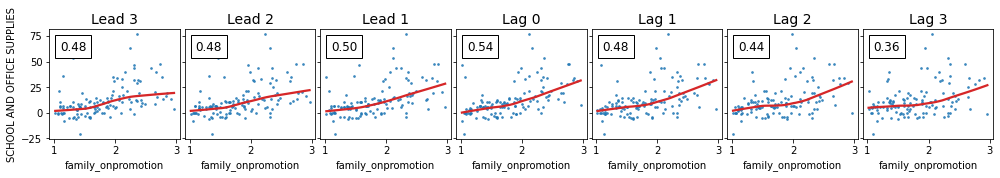

In [28]:
# show relationship with family
rfamily = 'SCHOOL AND OFFICE SUPPLIES'

# onpromotion data from train
onpromotion = train.unstack(['store_nbr', 'family']).drop('sales', axis=1).droplevel(0, axis=1).loc[sdate:edate]
onpromotion.name = 'onpromotion'
# group by family
family_onpromotion = ( 
    onpromotion
    .stack(['store_nbr','family'])
    .groupby(['family', 'date']).mean()
    .unstack('family')
    .loc(axis=1)[rfamily]                                  
    .squeeze()
    .rename('family_onpromotion')
)
plot_lags_leads(x=family_onpromotion.loc[family_onpromotion > 1], 
                y=y_des_family.loc[family_onpromotion > 1].loc(axis=1)[rfamily].rename(rfamily), 
                lags=3, leads=3, nrows=1);

**Lagged values**

Using the lagged values of the target y may account for the serial dependence in the time series. As sales values are available only for the training data set they could potentially be used to forecast just one date in test. Therefore a multistep regression will forecast the whole time horizon of test which also accounts for the serial dependence in y. It will be applied to the residuals resulting from the boosted hybrid.

Taking a look at for example the school and office supplies time series the partial autocorrelations suggest that some lags up to the 9th could be used. The lagplots indicate a mostly linear relationship but a non-linear relationship might play a role as well. Finally the number of lags will be chosen for all the product families together.

/opt/conda/lib/python3.7/site-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


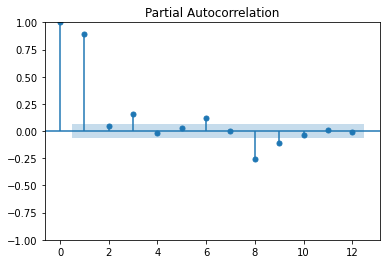

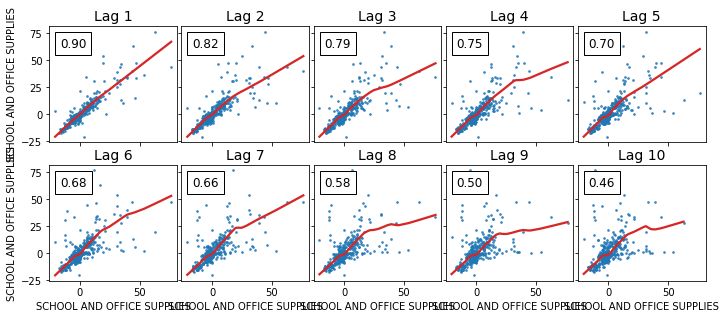

In [29]:
rfamily = 'SCHOOL AND OFFICE SUPPLIES'
plot_pacf(y_des_family.loc(axis=1)[rfamily].loc[sdate:edate], lags=12);
plot_lags_leads(y_des_family.loc(axis=1)[rfamily].loc[sdate:edate], lags=10, nrows=2);

**Building the features for XGBoost**

In [30]:
# add onpromotion data from test data set
onpromotion_test = test.drop('id', axis=1).unstack(['store_nbr', 'family']).droplevel(0, axis=1)
onpromotion = pd.concat([onpromotion, onpromotion_test]).sort_index()
onpromotion.name = 'onpromotion'

# add onpromotion time series as features
X2 = pd.concat([
    make_lags(onpromotion, lags=2),
    pd.concat({'onpromotion_lag_0': onpromotion}, names=[None, 'store_nbr', 'family'], axis=1),
    make_leads(onpromotion, leads=3)], 
    names=[None, 'store_nbr' ,'family'],
    axis=1)

X2 = X2.stack(['store_nbr', 'family'])

# experimenting with oil data without success
#oil_lags = make_lags(oil, lags=3)
#X2 = X2.join(oil_lags)
X2 = X2.fillna(0.0)

# Label encoding store_nbr and family
X2 = X2.reset_index(['store_nbr', 'family'])

for colname in X2.select_dtypes(["object", "category"]):
    X2[colname], _ = X2[colname].factorize()

X2_test = X2.loc["2017-08-16" : "2017-08-31"] # features for the test period
X2 = X2.loc[sdate : edate]

display(X2)

,store_nbr,family,onpromotion_lag_0,onpromotion_lag_01,onpromotion_lag_02,onpromotion_lead_00,onpromotion_lead_01,onpromotion_lead_02
date,,,,,,,,
2015-01-15,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2015-01-15,0,1,0.0,0.0,0.0,0.0,0.0,0.0
2015-01-15,0,2,0.0,0.0,0.0,0.0,0.0,0.0
2015-01-15,0,3,1.0,0.0,0.0,1.0,0.0,0.0
2015-01-15,0,4,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
2017-08-15,53,28,0.0,0.0,0.0,0.0,0.0,0.0
2017-08-15,53,29,1.0,0.0,1.0,1.0,1.0,0.0
2017-08-15,53,30,148.0,7.0,7.0,148.0,158.0,1.0


**The boosted hybrid model**

In [31]:
# this class combines linear regression or other model with XGBoost - from time series course
class BoostedHybrid:
    def __init__(self, model_1, model_2):
        self.model_1 = model_1
        self.model_2 = model_2
        self.y_columns = None  # store column names from fit method

def fit(self, X_1, X_2, y):
    model = self.model_1
    model.fit(X_1,y)

    y_fit = pd.DataFrame(
        model.predict(X_1),
        index=X_1.index, columns=y.columns,
    )

    y_resid = y - y_fit
  
    y_resid = y_resid.stack(list(range(y_resid.columns.nlevels))).squeeze() # stack all levels
    self.model_2.fit(X_2, y_resid)

    # Save column names for predict method
    self.y_columns = y.columns
    # Save data for question checking
    self.y_fit = y_fit
    self.y_resid = y_resid


# Add method to class
BoostedHybrid.fit = fit

def predict(self, X_1, X_2):
    y_pred = pd.DataFrame(
        self.model_1.predict(X_1),
        index=X_1.index, columns=self.y_columns,
    )

    y_pred = y_pred.stack(list(range(y_pred.columns.nlevels))).squeeze() # stack all levels

    y_pred += self.model_2.predict(X_2)
    
    return y_pred.unstack(list(range(y_pred.index.nlevels)[1:])) # unstack all levels except the first


# Add method to class
BoostedHybrid.predict = predict

bhybrid = BoostedHybrid(LinearRegression(fit_intercept=False), XGBRegressor(n_estimators=150, eta=0.12, max_depth=6))


# Features for the multistep regression

The multistep regression uses the residuals of the boosted hybrid. 

In [32]:
# calculating the residuals of the boosted hybrid prediction
bhybrid.fit(X1, X2, y)
y_fit = bhybrid.predict(X1, X2).clip(0.0)
y_pred = bhybrid.predict(X1_test, X2_test).clip(0.0) # also needed for the submission
y_resid = y - y_fit
y_resid.name = 'sales_residuals'

**Building the features for the multistep regression**

In [33]:
# the features for the multistep regression

# using the lagged residuals as features for the forecast
X3 = make_lags(y_resid, lags=8).dropna(axis=0)
X3_test = X3.loc[['2017-08-15']] # features for the test forecast

# generating the multistep target ym
nsteps = 16 # number of multistep targets
ym = make_multistep_target(y_resid, steps=nsteps).dropna(axis=0)
ym, X3 = ym.align(X3, join='inner', axis=0)
ym = ym.stack(['store_nbr', 'family'])  # wide to long

# encoding labels
le = LabelEncoder()
X3 = (X3
    .stack(['store_nbr', 'family'])  # wide to long
    .reset_index(['store_nbr','family'])  # convert index to column
    .assign(store_nbr=lambda x: le.fit_transform(x.store_nbr))  # label encode store_nbr
    .assign(family=lambda x: le.fit_transform(x.family))  # label encode family
)

X3_test = (X3_test
    .stack(['store_nbr', 'family'])  # wide to long
    .reset_index(['store_nbr','family'])  # convert index to column
    .assign(store_nbr=lambda x: le.fit_transform(x.store_nbr))  # label encode store_nbr
    .assign(family=lambda x: le.fit_transform(x.family))  # label encode family
)

display(X3)

,store_nbr,family,sales_residuals_lag_01,sales_residuals_lag_02,sales_residuals_lag_03,sales_residuals_lag_04,sales_residuals_lag_05,sales_residuals_lag_06,sales_residuals_lag_07,sales_residuals_lag_08
date,,,,,,,,,,
2015-01-23,0,0,0.368018,-1.965403,-2.284096,1.544851,3.000000,2.985605,-2.367776,1.013039
2015-01-23,0,1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2015-01-23,0,2,0.558997,-0.629414,-1.303923,-0.492839,1.913738,-0.847873,-0.770733,2.709967
2015-01-23,0,3,205.005066,-58.407122,119.884325,-0.315573,516.000000,365.074364,224.203814,237.145266
2015-01-23,0,4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...
2017-07-31,53,28,-119.168726,-100.186709,125.772897,17.073384,83.331971,-7.343837,-69.408615,-91.610316
2017-07-31,53,29,-9.668285,11.684857,-28.972148,-1.185475,-36.021863,-48.483770,-9.042688,-53.842384
2017-07-31,53,30,-529.939704,-123.644167,-143.469232,-153.792934,-233.536650,-283.968573,-18.340796,-160.563017


# Evaluation of the boosted hybrid

In [35]:
# evaluating the boosted hybrid

y_train, y_valid = y[: "2017-07-30"], y["2017-07-31" :] # last 16 days for validation
X1_train, X1_valid = X1[: "2017-07-30"], X1["2017-07-31" :]
X2_train, X2_valid = X2[: "2017-07-30"], X2["2017-07-31" :]

bhybrid.fit(X1_train, X2_train, y_train)

y_fit_boosted = bhybrid.predict(X1_train, X2_train).clip(0.0)
y_pred_boosted = bhybrid.predict(X1_valid, X2_valid).clip(0.0)

rmsle_train_boosted = mean_squared_log_error(y_train, y_fit_boosted, squared=False)
rmsle_valid_boosted = mean_squared_log_error(y_valid, y_pred_boosted, squared=False)

print(f'Training boosted hybrid RMSLE: {rmsle_train_boosted:.5f}')
print(f'Validation boosted hybrid RMSLE: {rmsle_valid_boosted:.5f}')

'Training boosted hybrid RMSLE: 0.63659'

'Validation boosted hybrid RMSLE: 0.45738'

# Evaluation of the multistep regression

In [36]:
# evaluating the multiple target step regression
# this cell takes a while

mtsdate = '2017-04-05' # start of training for multitarget regression

ym_train, ym_valid = ym.loc[mtsdate: '2017-07-15'], ym.loc['2017-07-30']
X3_train, X3_valid = X3.loc[mtsdate: '2017-07-15'], X3.loc['2017-07-30']

mtxgb = RegressorChain(XGBRegressor(n_estimators=150, eta=0.1, max_depth=12))

mtxgb.fit(X3_train, ym_train)

ym_fore_boosted = pd.DataFrame(mtxgb.predict(X3_valid), index=ym_valid.index, columns=ym_valid.columns).clip(0.0)

# reshape the row of forecasted values:
ym_fore_boosted = (
    ym_fore_boosted
    .stack()
    .reset_index()
    .drop(columns=['date']) # drop former date column
    # replace 'Y_step_01' to 'y_step_16' by dates from '2017-07-31' to '2017-08-15':
    .replace([f'y_step_{f"{(i+1):02}"}' for i in range(nsteps)], pd.date_range('2017-07-31', '2017-08-15').to_period('D'))
    .rename(columns={'level_3' : 'date', 0 : 'sales'})
    .set_index(['date','store_nbr', 'family'])
    .sort_index()
    .unstack(['store_nbr', 'family'])
    .droplevel(0, axis=1)
)

rmsle_valid_mboosted = mean_squared_log_error(y_valid, (ym_fore_boosted + y_pred_boosted), squared=False)
display(f'Validation multitarget XGBR RMSLE: {rmsle_valid_mboosted:.5f}')

rmsle_family_valid_mboosted = (ym_fore_boosted + y_pred_boosted).stack(['store_nbr', 'family']).rename('sales').to_frame()
rmsle_family_valid_mboosted['true_sales'] = y_valid.stack(['store_nbr', 'family'])
rmsle_family_valid_mboosted.groupby('family').apply(lambda r: mean_squared_log_error(r['sales'], r['true_sales'], squared=False))

'Validation multitarget XGBR RMSLE: 0.44892'

family
AUTOMOTIVE                    0.557687
BABY CARE                     0.329863
BEAUTY                        0.708795
BEVERAGES                     0.303186
BOOKS                         0.161875
BREAD/BAKERY                  0.225290
CELEBRATION                   0.604292
CLEANING                      0.377469
DAIRY                         0.229133
DELI                          0.273514
EGGS                          0.431855
FROZEN FOODS                  0.518107
GROCERY I                     0.201158
GROCERY II                    0.709224
HARDWARE                      0.564212
HOME AND KITCHEN I            0.588975
HOME AND KITCHEN II           0.641576
HOME APPLIANCES               0.324486
HOME CARE                     0.391274
LADIESWEAR                    0.699087
LAWN AND GARDEN               0.680155
LINGERIE                      0.810016
LIQUOR,WINE,BEER              0.775008
MAGAZINES                     0.536694
MEATS                         0.395494
PERSONAL CARE     

# Submission

In [19]:
mtxgb.fit(X3.loc[mtsdate:], ym.loc[mtsdate:])
ym_fore = pd.DataFrame(mtxgb.predict(X3_test), index=y.loc[['2017-08-15']].stack(['store_nbr', 'family']).index, columns=ym.columns).clip(0.0)

# reshape the row of forecasted values:
ym_fore = (
    ym_fore
    .stack()
    .reset_index()
    .drop(columns=['date']) # drop former date column
    # replace 'Y_step_01' to 'y_step_16' by dates from '2017-08-16' to '2017-08-31':
    .replace([f'y_step_{f"{(i+1):02}"}' for i in range(nsteps)], pd.date_range('2017-08-16', '2017-08-31').to_period('D'))
    .rename(columns={'level_3' : 'date', 0 : 'sales'})
    .set_index(['date','store_nbr', 'family'])
    .sort_index()
    .unstack(['store_nbr', 'family'])
    .droplevel(0, axis=1)
)

y_submit = y_pred + ym_fore
y_submit = y_submit.stack(['store_nbr', 'family']).rename('sales').to_frame()
y_submit = y_submit.join(test.id).reindex(columns=['id', 'sales'])
y_submit.to_csv('submission.csv', index=False)

display(y_submit)

id        sales
date       store_nbr family                                          
2017-08-16 1         AUTOMOTIVE                  3000888     5.616318
                     BABY CARE                   3000889     0.167892
                     BEAUTY                      3000890     7.972466
                     BEVERAGES                   3000891  2727.037328
                     BOOKS                       3000892     0.167892
...                                                  ...          ...
2017-08-31 9         POULTRY                     3029395   392.665239
                     PREPARED FOODS              3029396   110.351481
                     PRODUCE                     3029397  1644.432113
                     SCHOOL AND OFFICE SUPPLIES  3029398   194.500722
                     SEAFOOD                     3029399    15.836475

[28512 rows x 2 columns]

Thank you for reading!